In [8]:
import matplotlib.pyplot as plt
import numpy as np
import mplhep as hep
from scipy.interpolate import UnivariateSpline
from scipy.signal import find_peaks

In [10]:
with open('Run2.pkl', 'rb') as file:
    # Load the data from the pickle file
    din = pickle.load(file)
    
with open('pedestal_data.pkl', 'rb') as file:
    # Load the data from the pickle file
    ped = pickle.load(file)
    
HGPedMean = ped['HGPedMean']

In [6]:
def configure_plotting():
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['savefig.facecolor'] = 'white'
    plt.rcParams['savefig.bbox'] = 'tight'
    hep.style.use(hep.style.CMS)

# Process a single channel and return the estimated MIP peak position
def process_channel(data, channel_key, ax):
    data = np.array(data[channel_key])
    counts, bin_edges = np.histogram(data, bins=100, range=[0, 7500])
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    errors = np.sqrt(counts)

    # Plot raw data
    ax.errorbar(bin_centers, counts, yerr=errors, fmt='o', label=channel_key)

    # Smooth histogram with spline
    spline = UnivariateSpline(bin_centers, counts, s=5000, k=3)
    interp_x = np.linspace(bin_centers[0], bin_centers[-1], 1000)
    interp_y = spline(interp_x)

    # Find peaks
    peaks, _ = find_peaks(interp_y, height=0)
    peak_positions = interp_x[peaks]
    mip_peak = 0
    for pos in peak_positions:
        if 3000 <= pos <= 6000:
            mip_peak = pos
            break

    ax.axvline(x=mip_peak)
    ax.plot(interp_x, interp_y, linestyle="--")
    ax.set_yscale('log')
    ax.legend()
    ax.set_ylim(10, 10000)

    return mip_peak

# Analyze all channels for a given CAEN unit and return MIP values
def analyze_caen_unit(din, caen_unit, MIPs):
    num_channels = 64
    num_cols = 8
    num_rows = 8

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 30), sharey=True, sharex=True)
    axes = axes.flatten()

    for i in range(num_channels):
        channel_key = f"{i + (64 * caen_unit)}_HG"
        mip = process_channel(din, channel_key, axes[i])
        MIPs.append(mip)

        if i % num_cols == 0:
            axes[i].set_ylabel('Count')
        if i >= (num_rows - 1) * num_cols:
            axes[i].set_xlabel('ADC')

    plt.tight_layout(pad=0.0)
    plt.tight_layout(rect=[0, 0, 1.5, 1])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

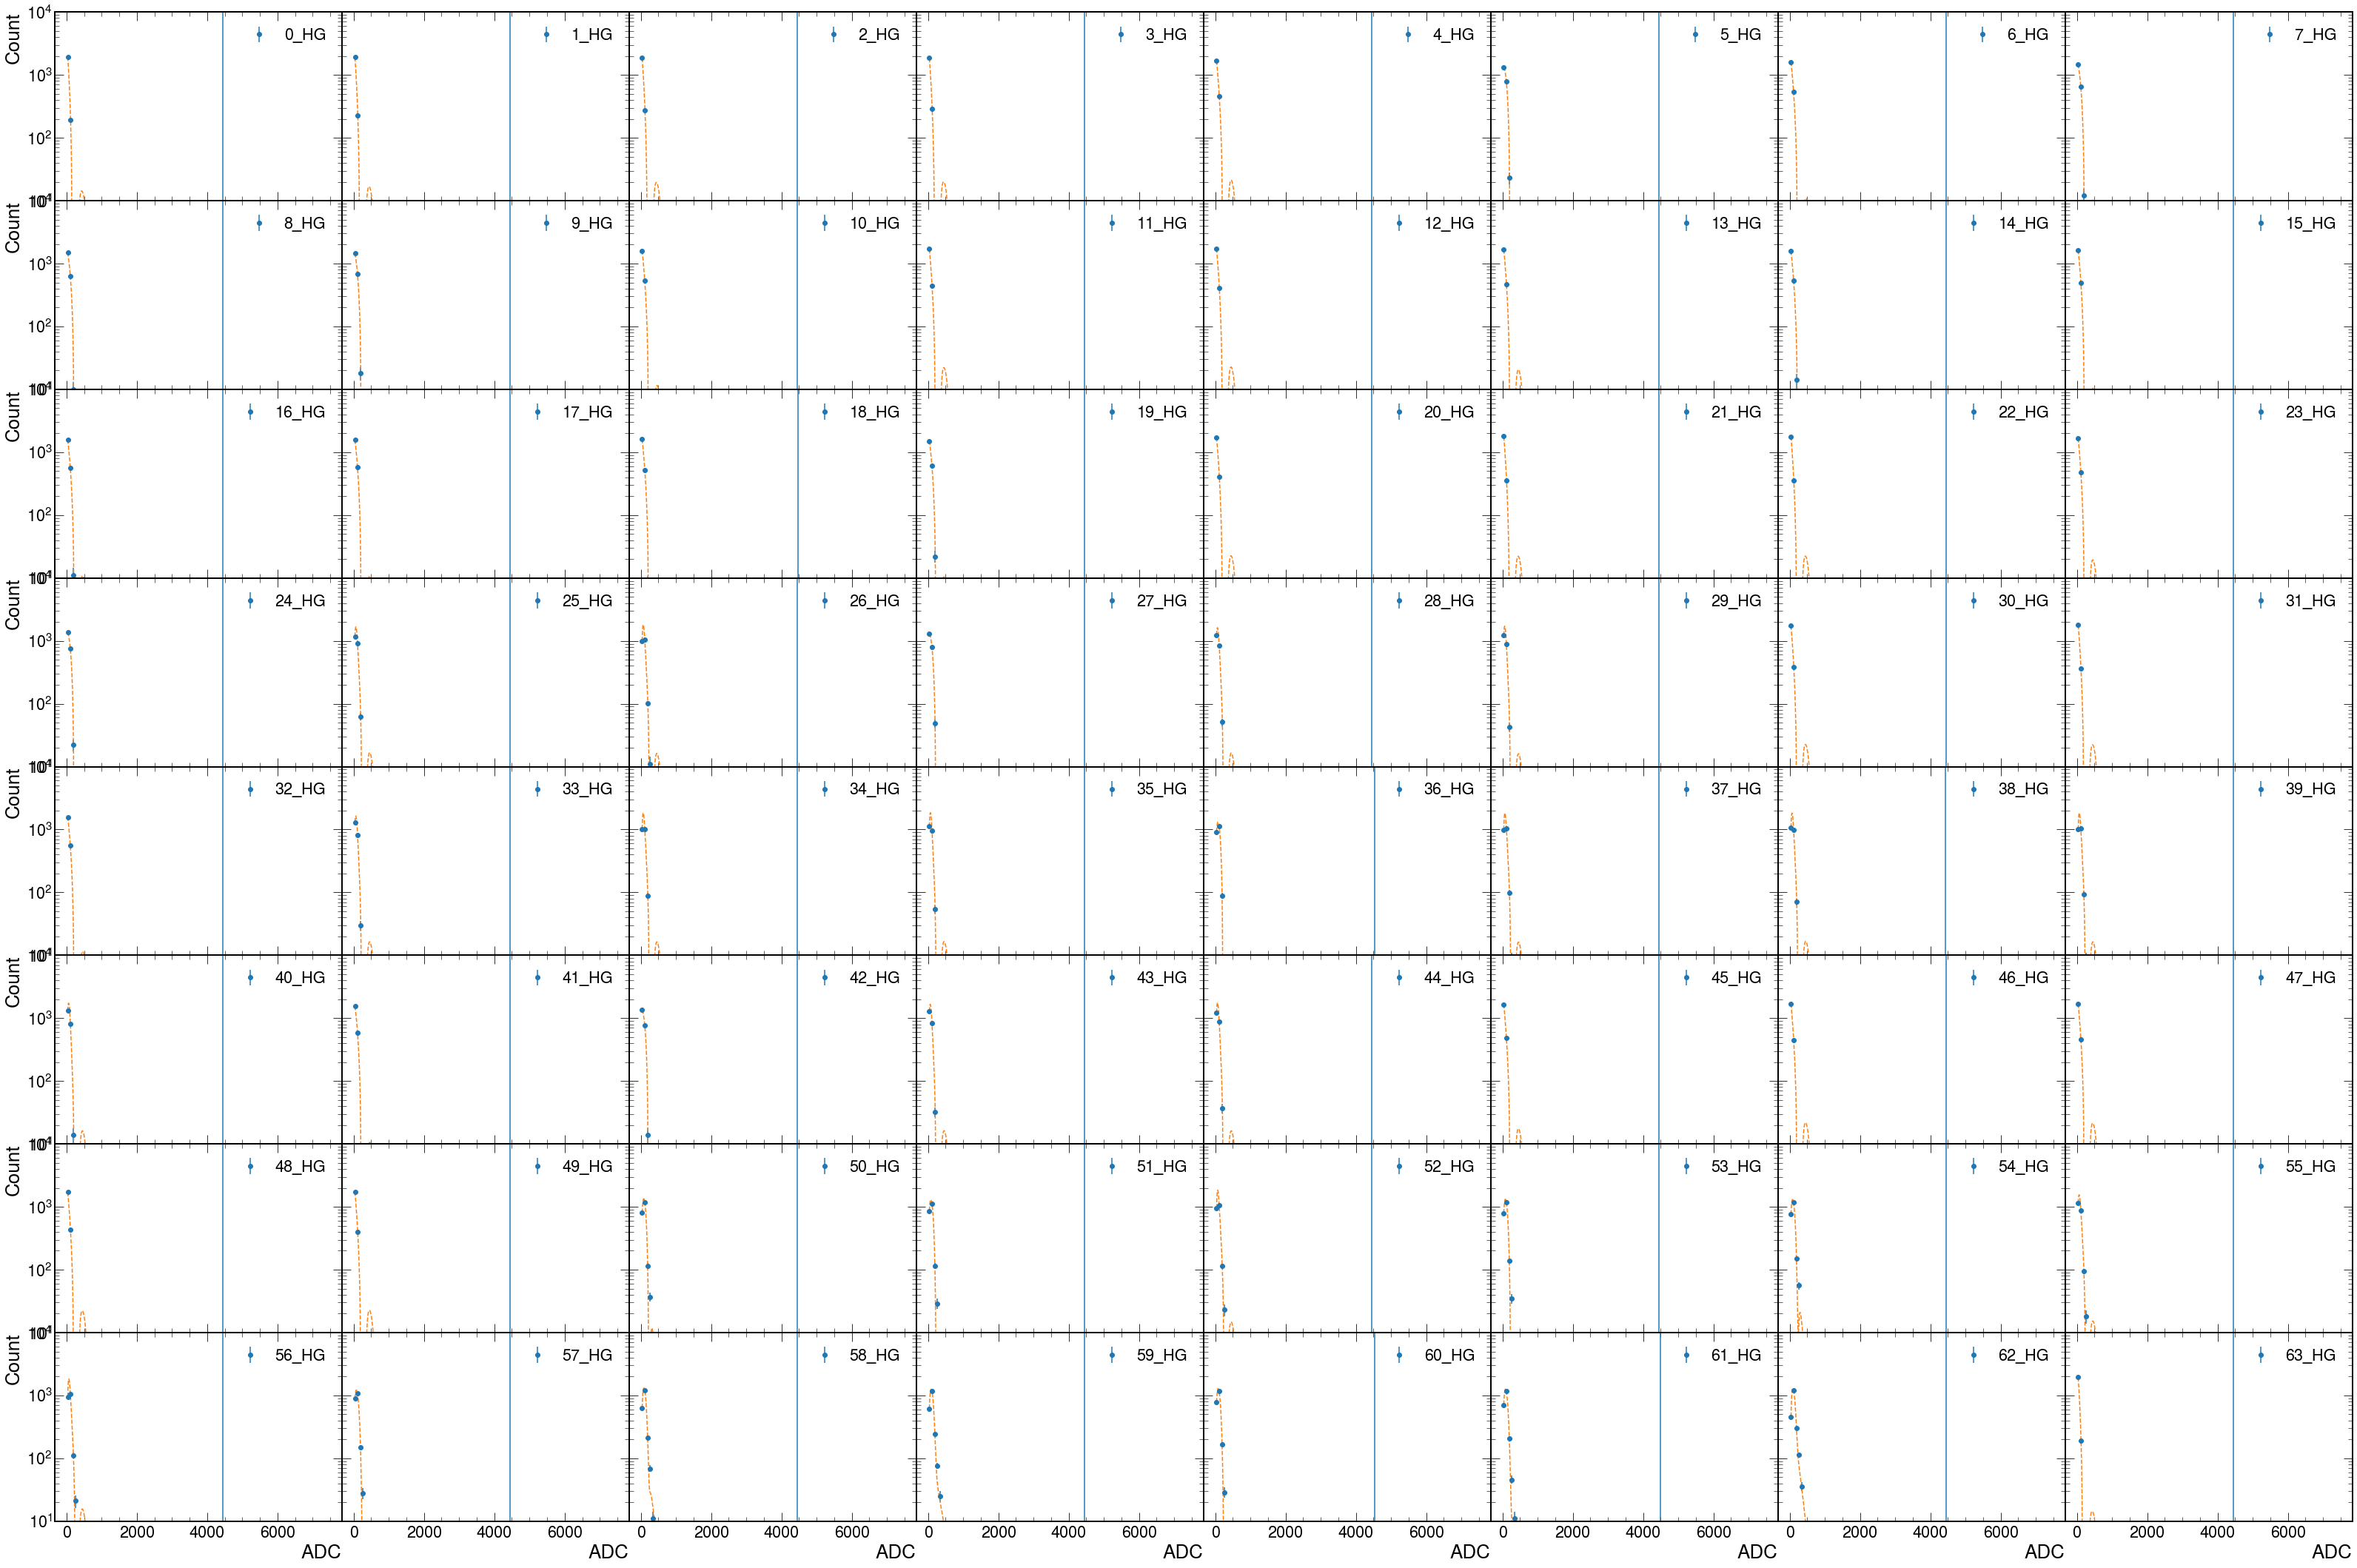

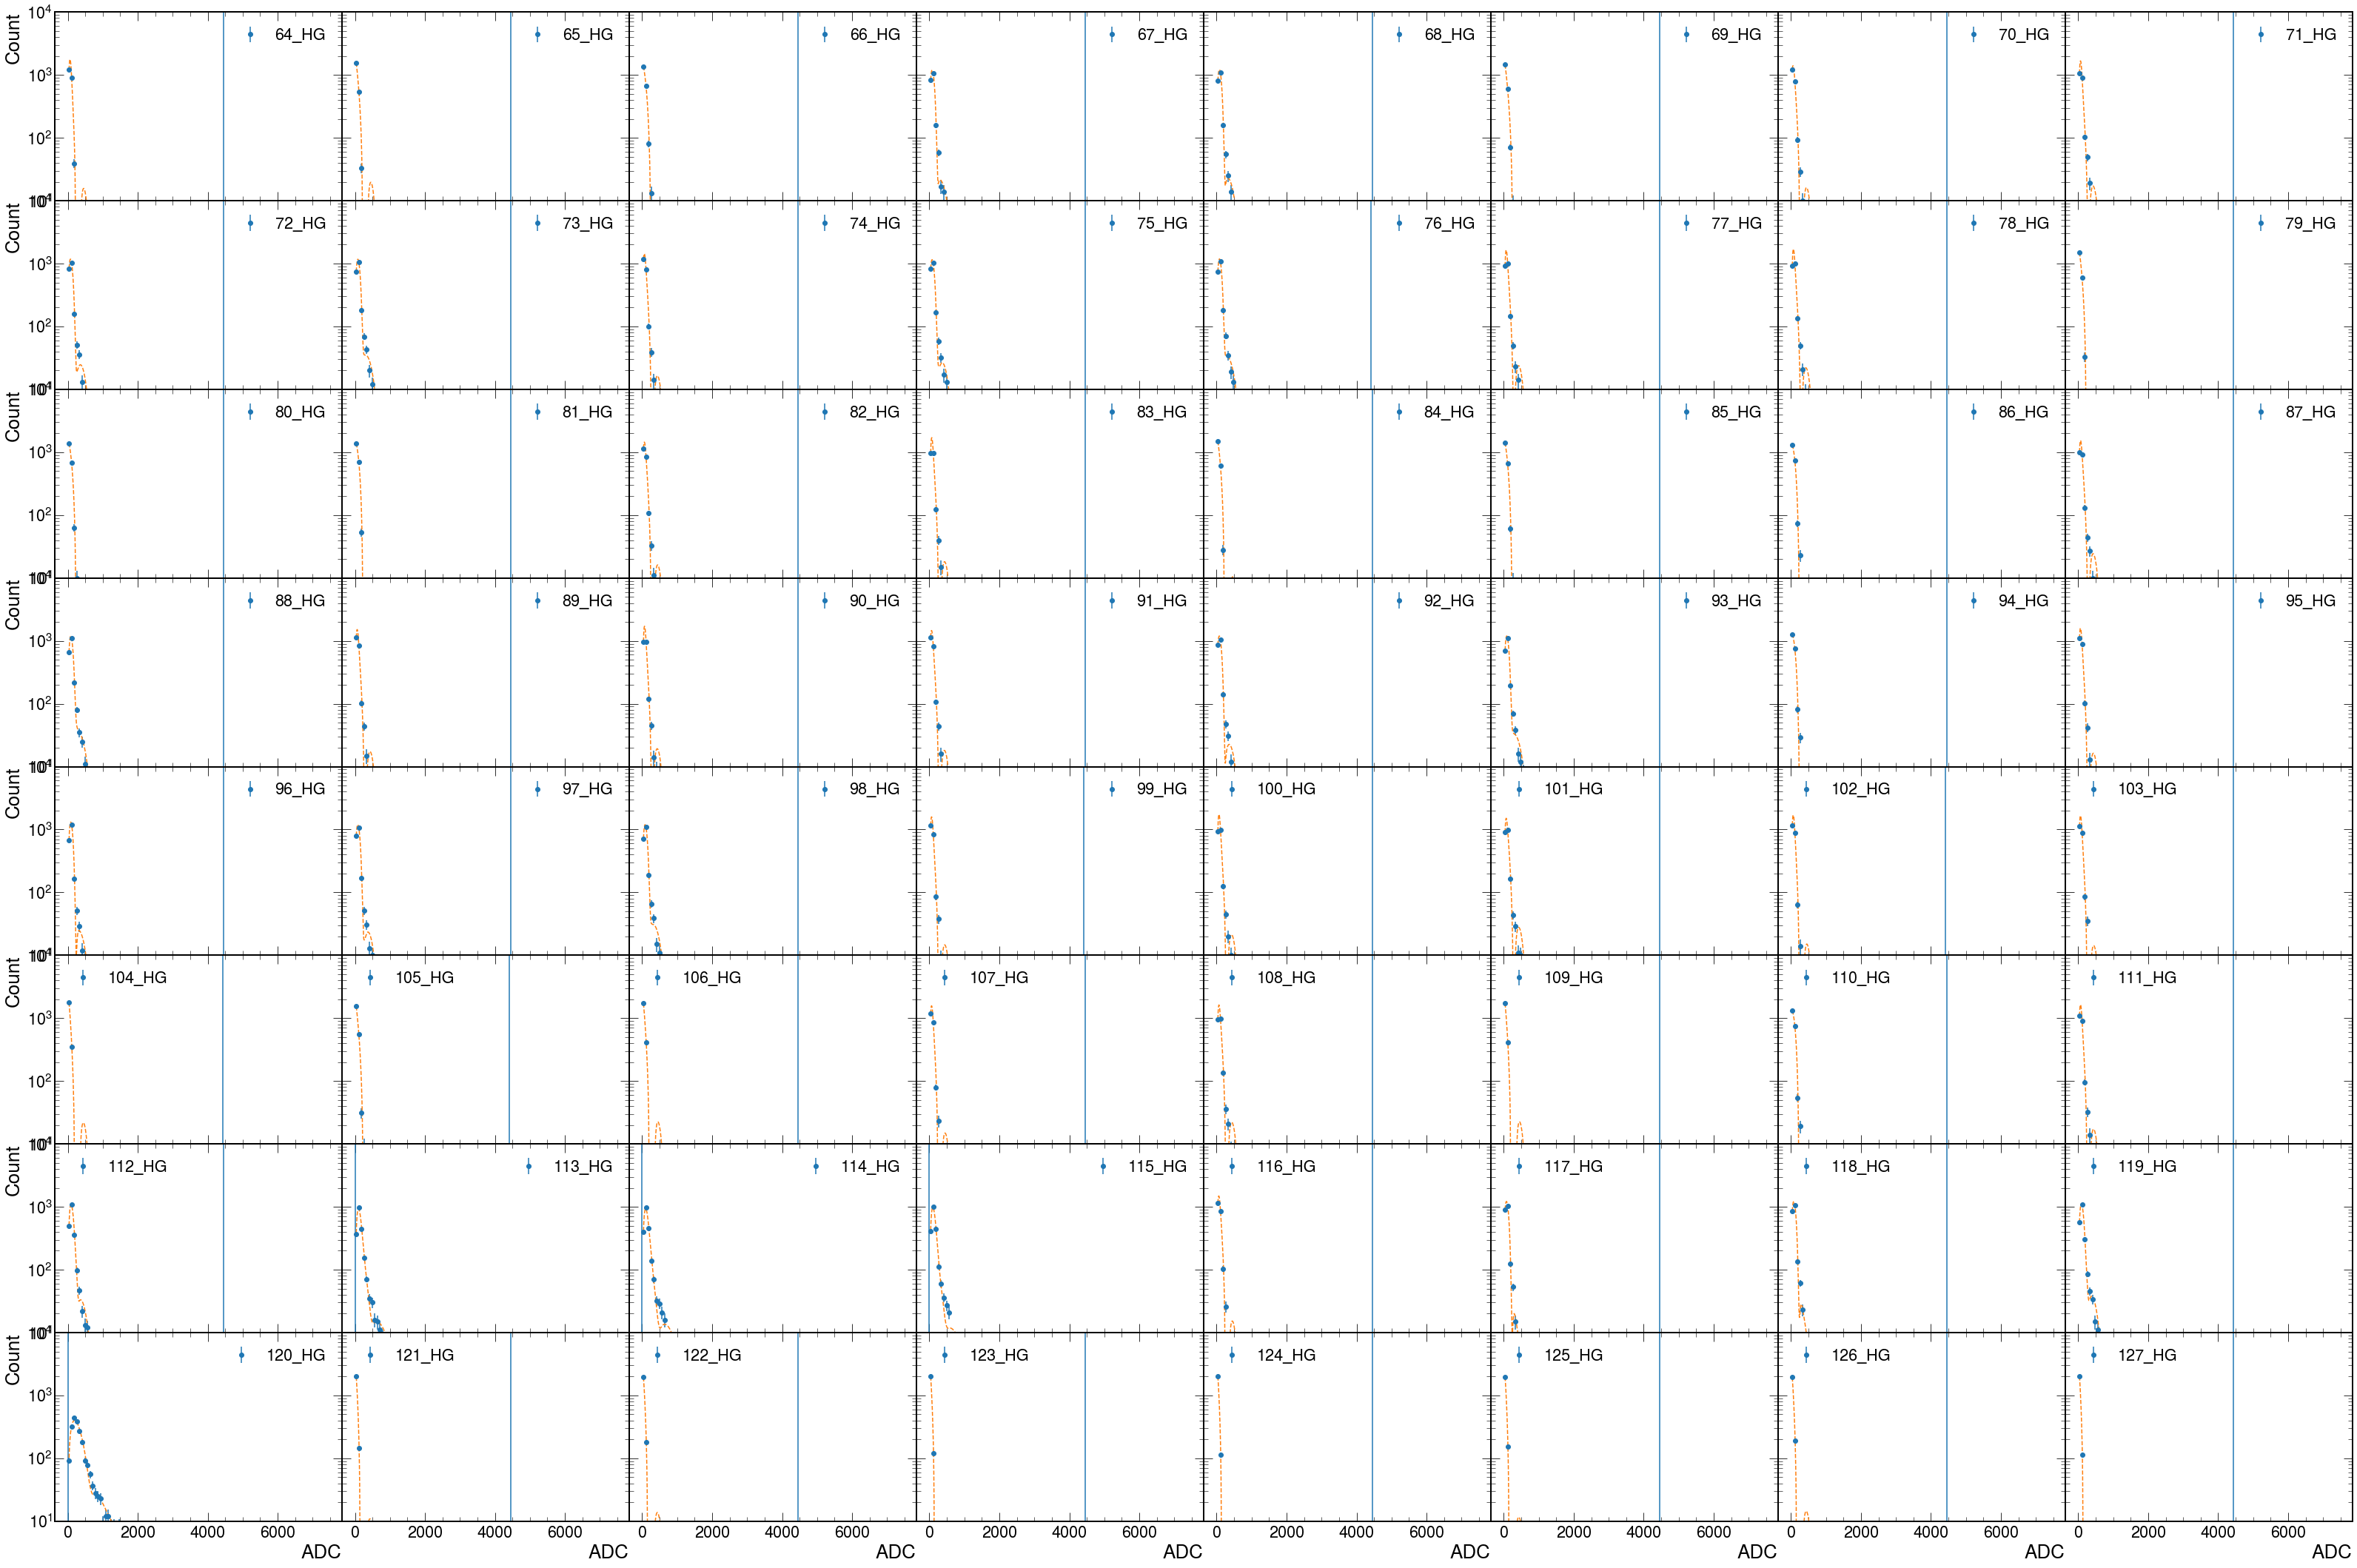

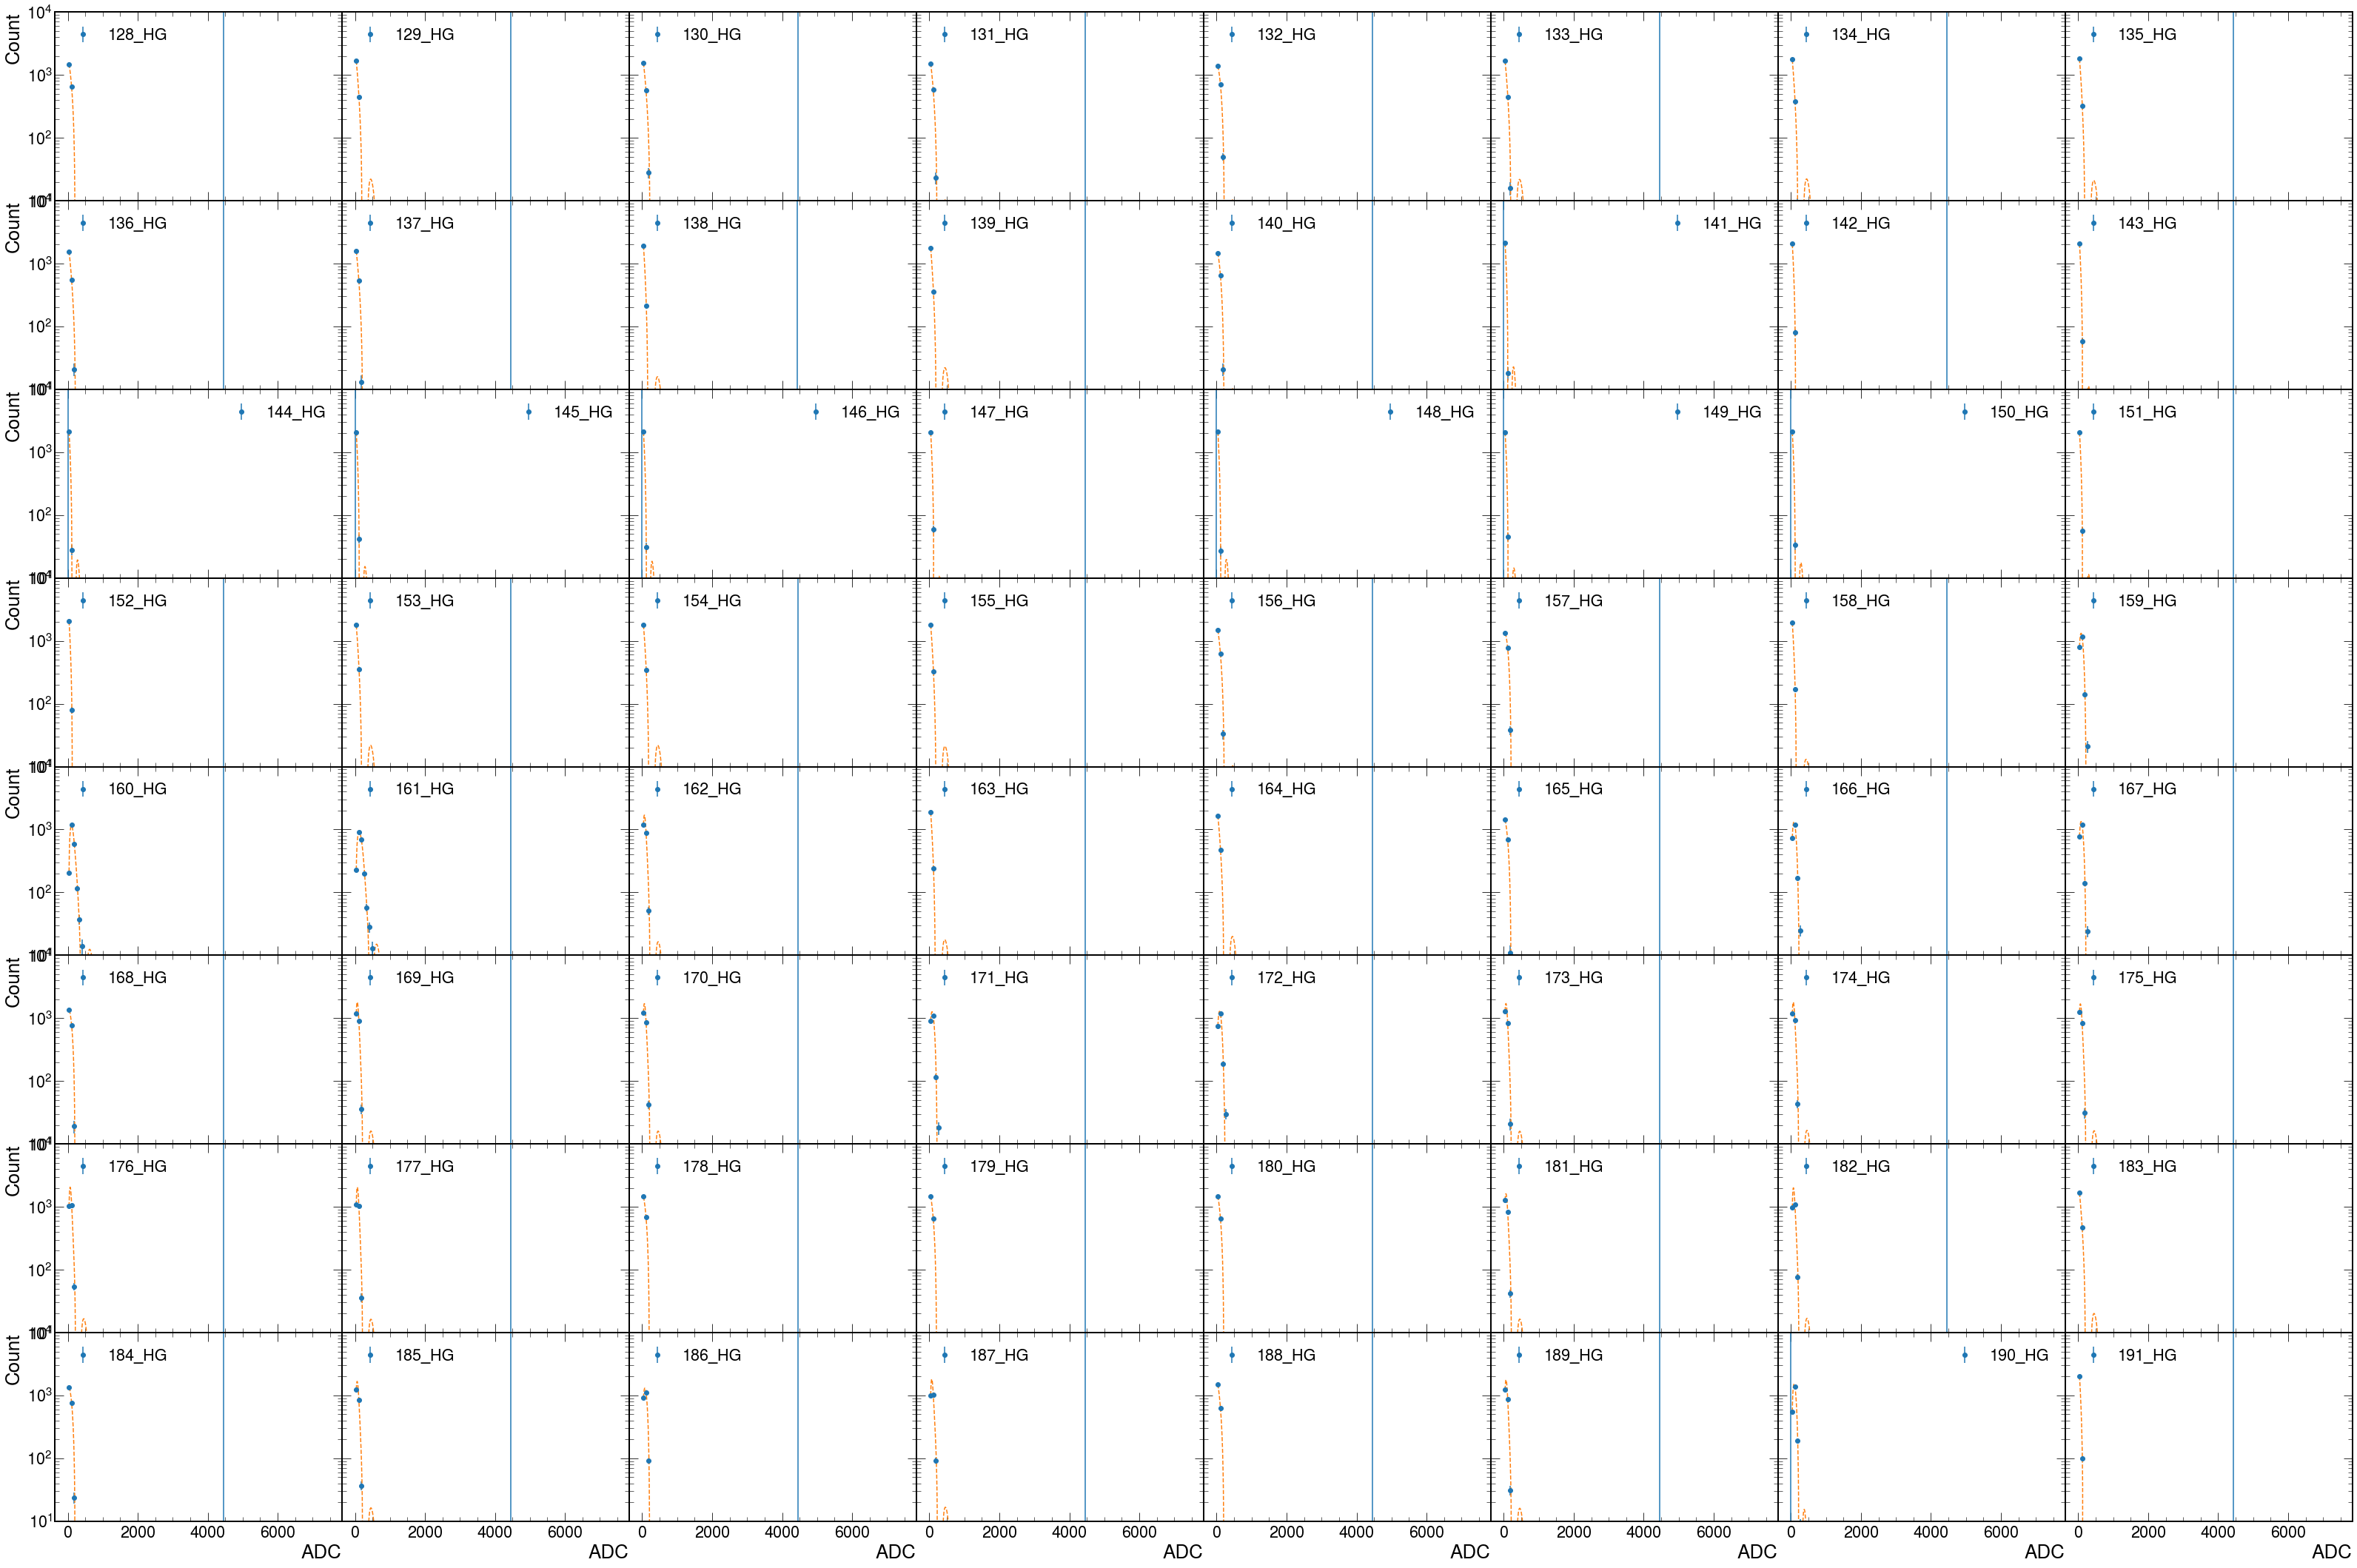

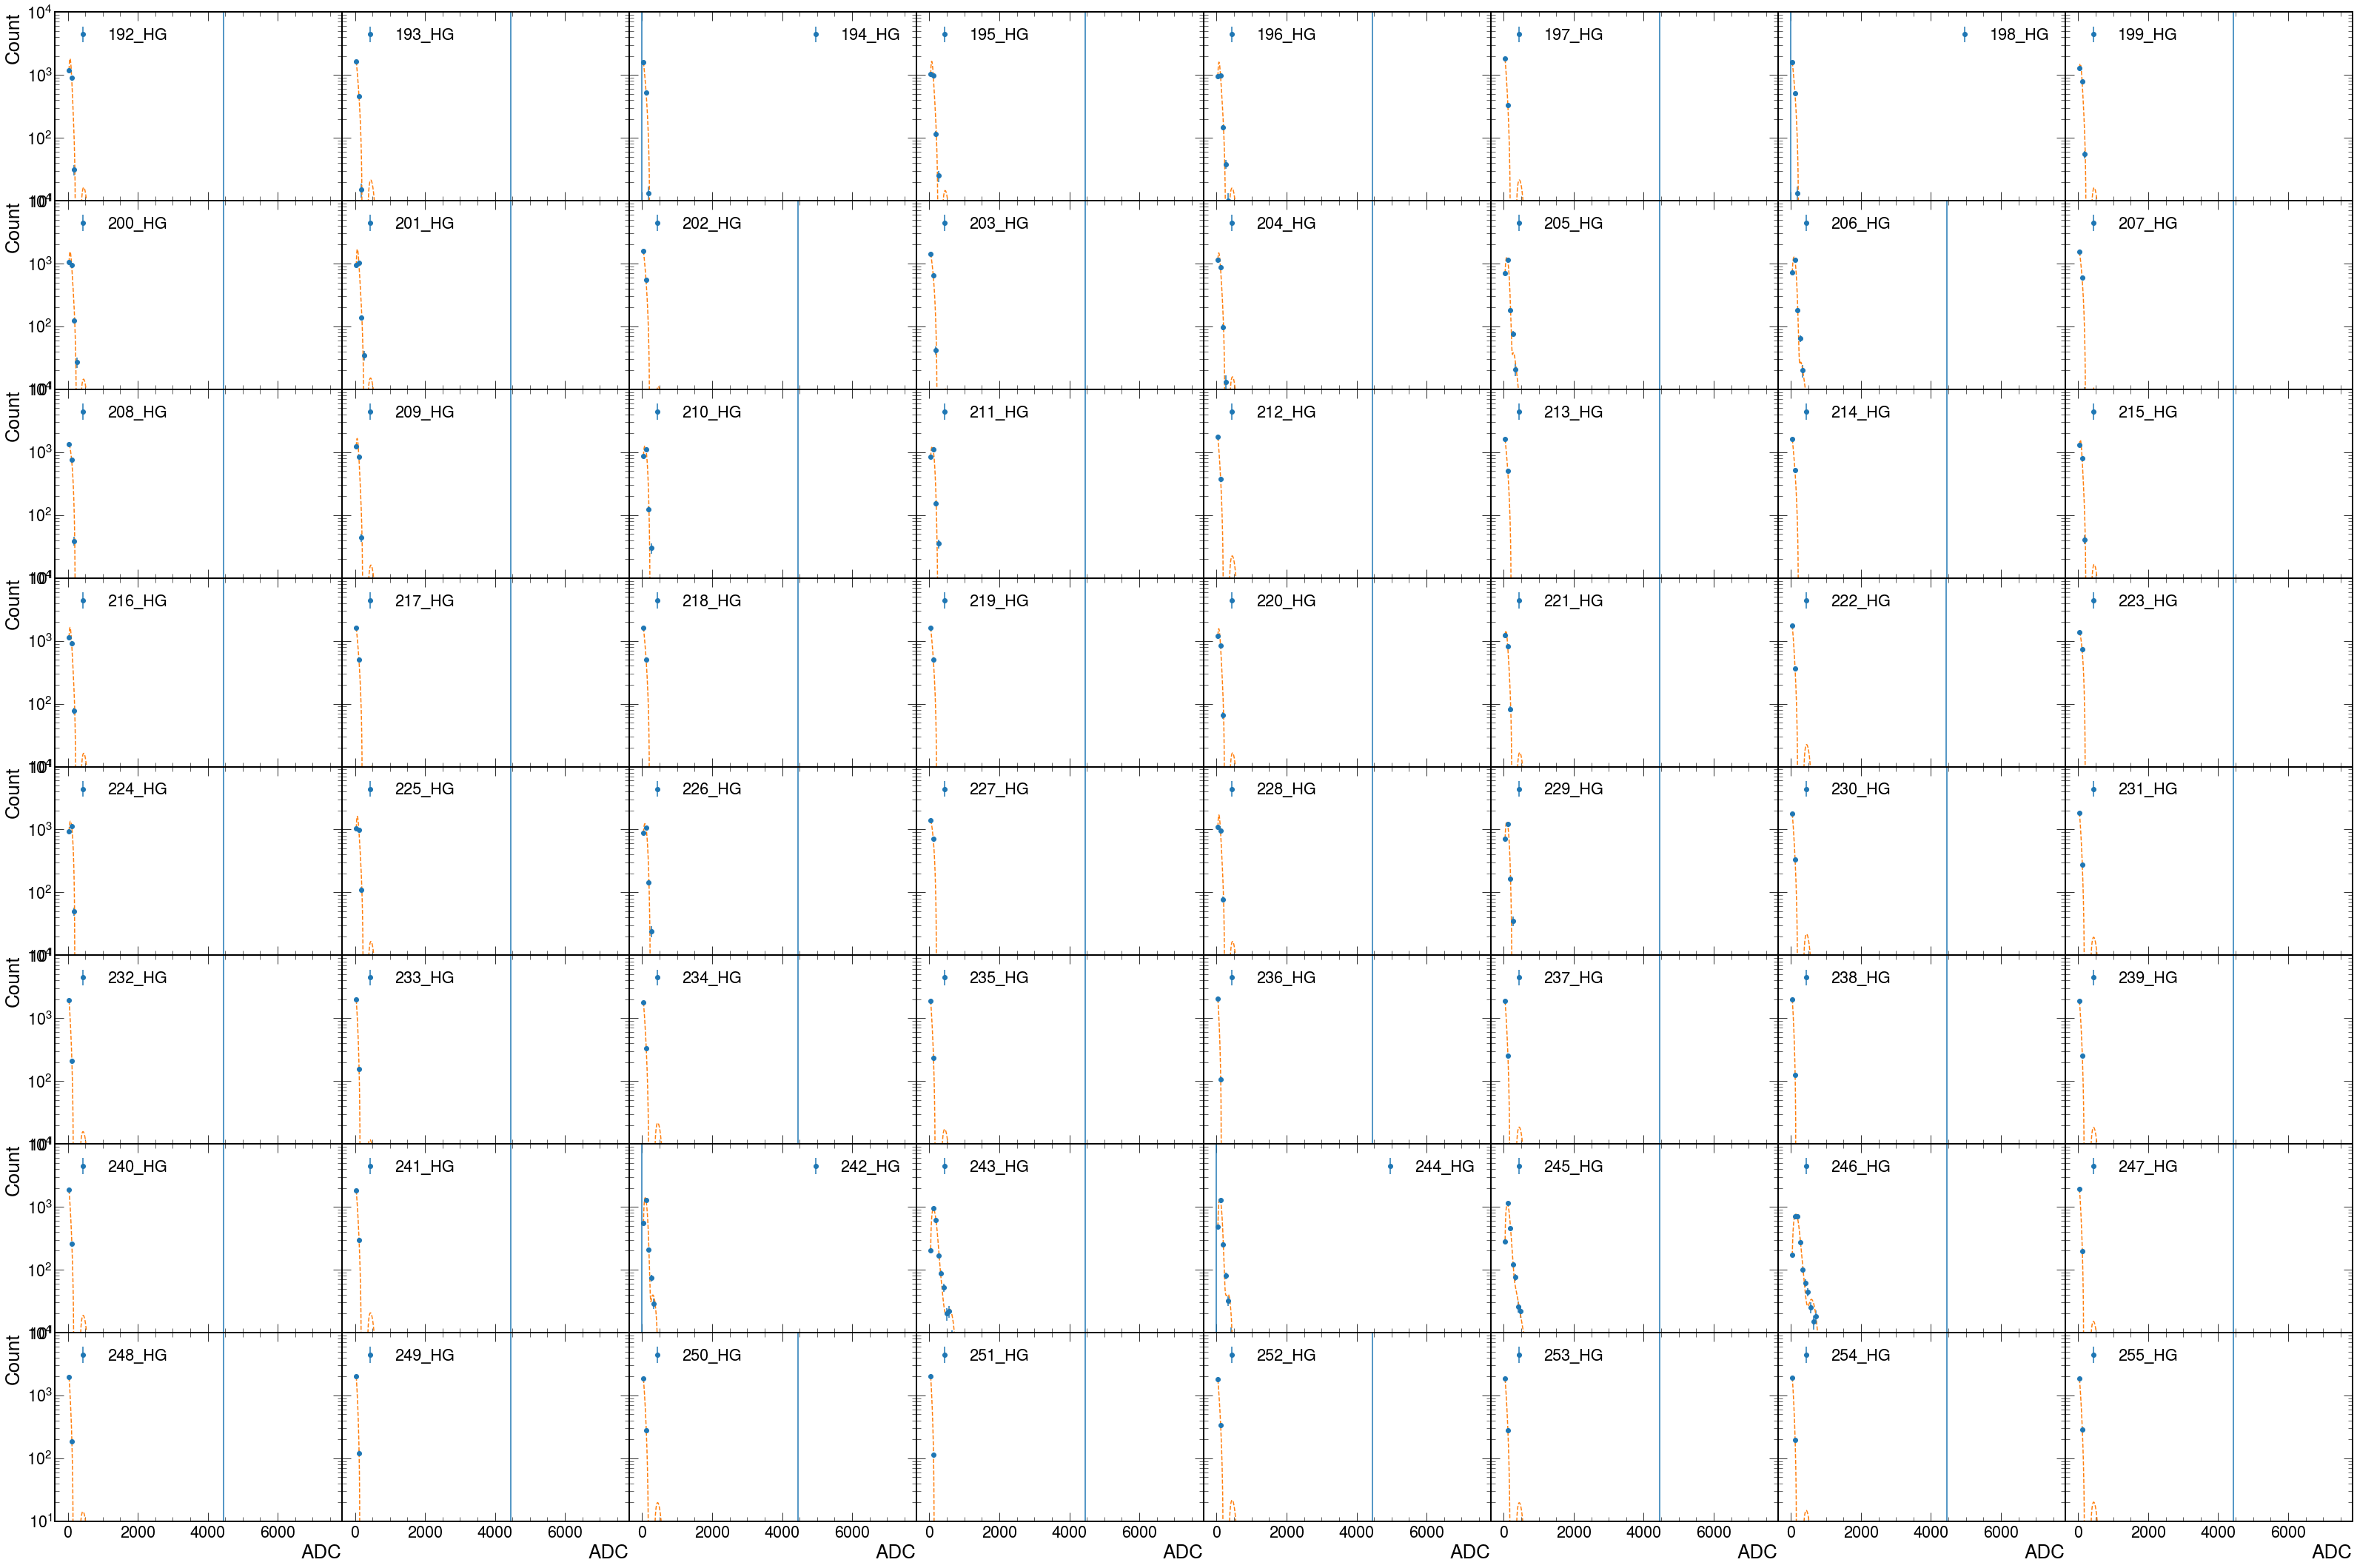

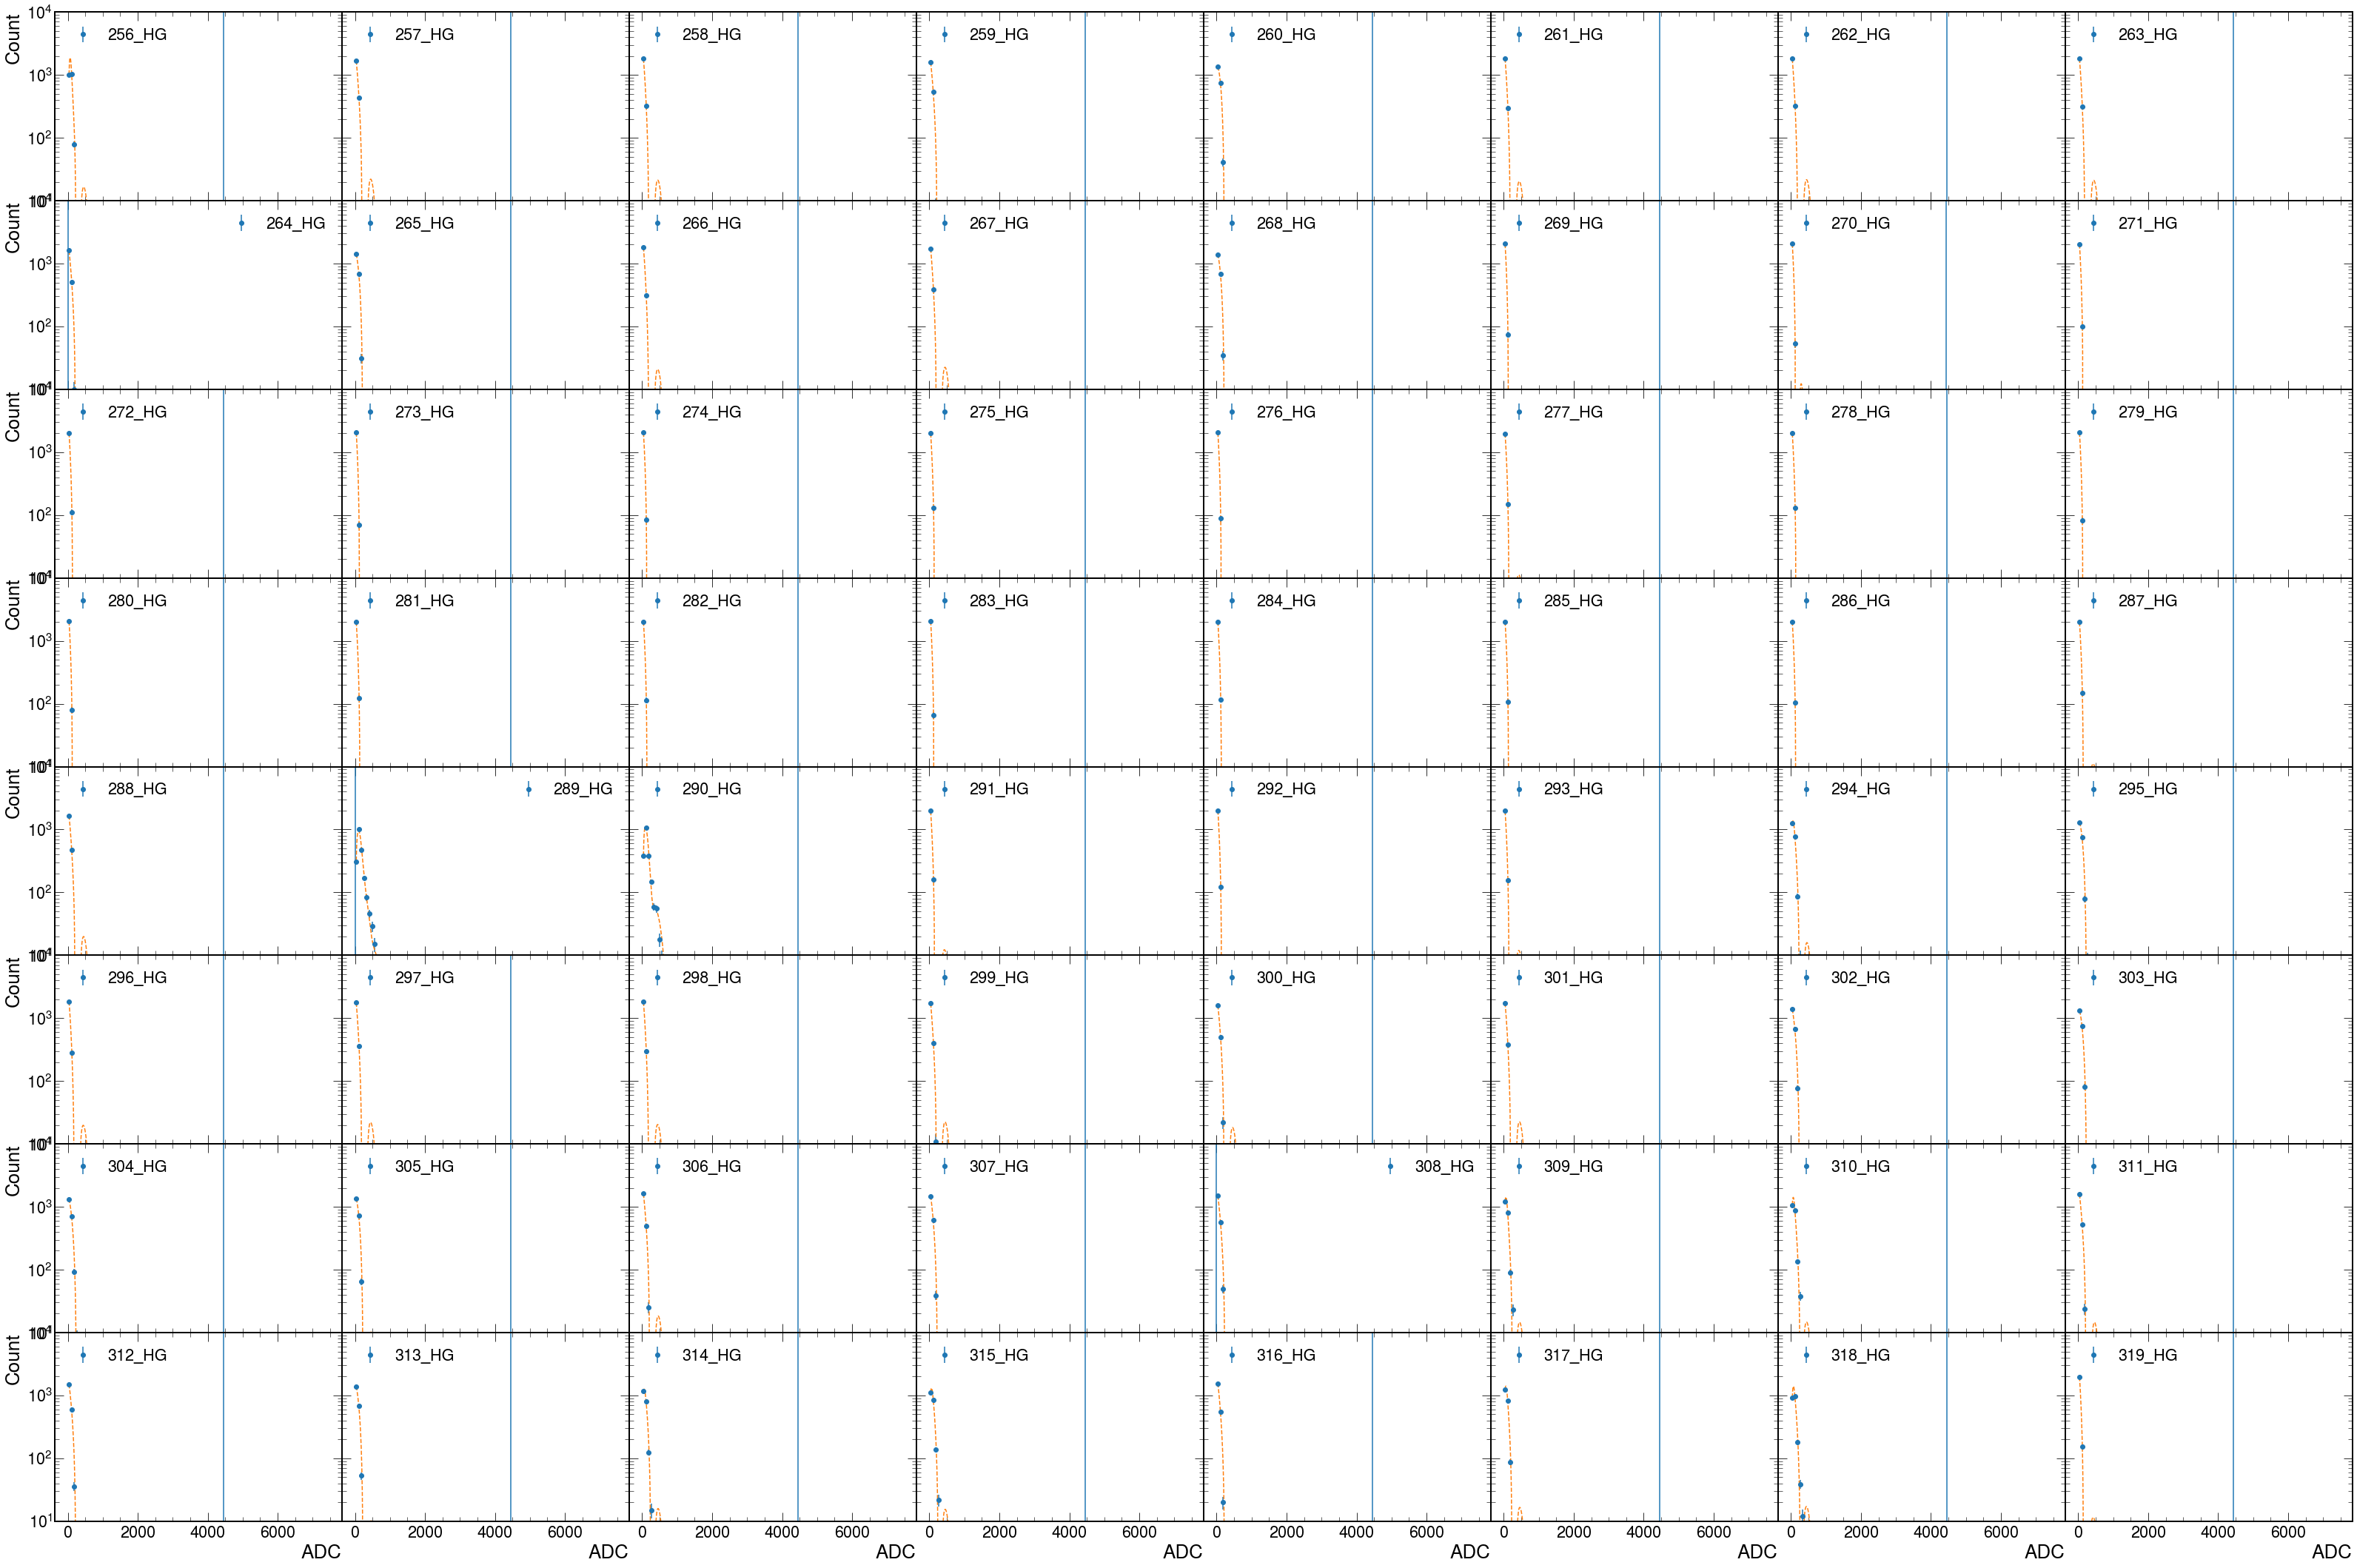

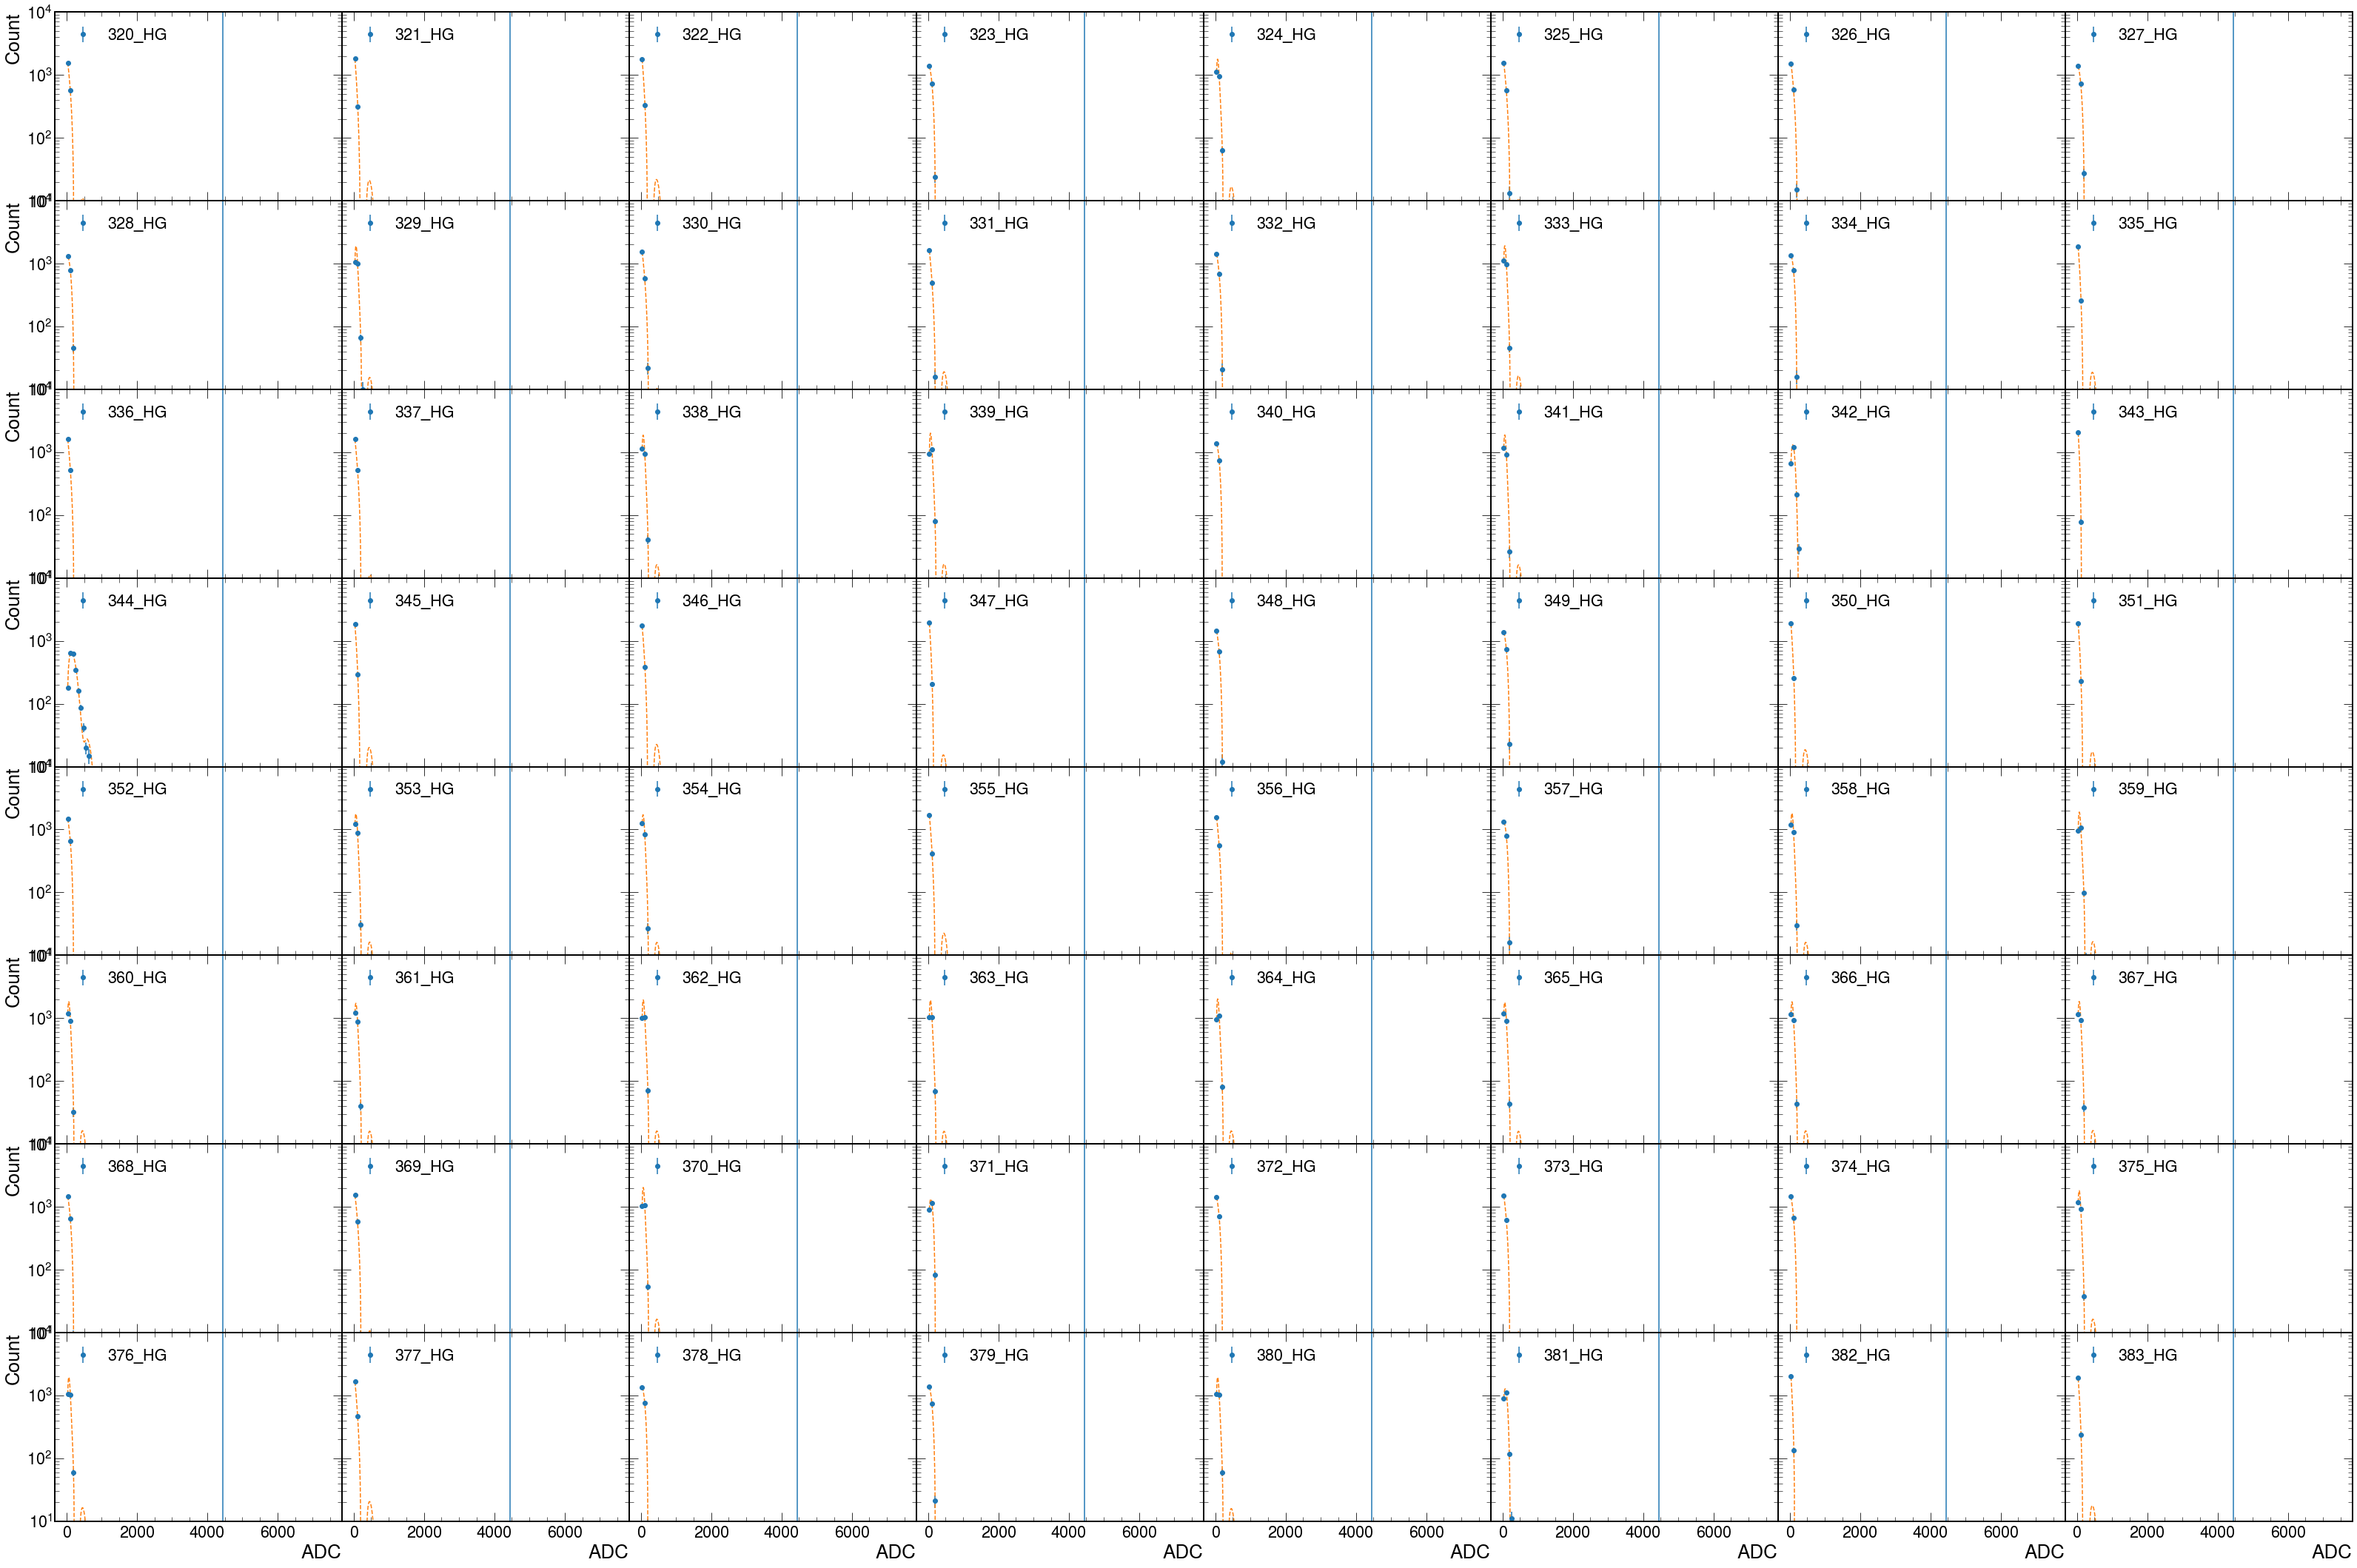

In [9]:
MIPs = []
configure_plotting()
for unit in range(6):
    analyze_caen_unit(din, unit, MIPs)

In [15]:
new_MIPs = np.array(MIPs) - np.array(HGPedMean)

In [16]:
with open('MIPs.pkl', 'wb') as f:
    pickle.dump(new_MIPs, f)